In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc
import math
import pandas as pd

In [2]:
## Setting max displayed rows to 500, in order to display the full output of any command 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])
df_train = df_train.sort_values(by='date')
df_train["rescaled_sold"] = df_train.groupby(["country", "store", "product"])["num_sold"].transform(lambda s: s/s.mean())

rescaled_df = df_train.groupby(["country", "product", "date"])["rescaled_sold"].mean().reset_index()

df_train.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'rescaled_sold'], dtype='object')

In [3]:
df_test = pd.read_csv("test.csv")
df_test["date"] = pd.to_datetime(df_test["date"])
df_test = df_test.sort_values(by='date')

In [4]:
def plot_scatter_grid(df, cols, pred, ncols=3, figsize=(16, 10), intensity = .1):
    n_plots = len(cols)
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        if len(col) == 3:
            c,s,p = col
            grouped = df.loc[(df["country"] == c) & (df["store"] == s) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {s}, {p}")
            ax.tick_params(axis="x", labelrotation=45)
        elif len(col) == 2:
            c,p = col
            grouped = df.loc[(df["country"] == c) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {p}")
            ax.tick_params(axis="x", labelrotation=45)

    # remove unused axes
    for ax in axes[len(cols):]:
        ax.remove()
    plt.tight_layout()
    plt.show()



# Take-away: we should be able to drop the rows with missing data safely.

### For each product and country, we average over all stores

Hypothesis to test: Kaggle Tiers and Kaggle are CORRELATED, have the SAME CHANGE POINTS, and they are QUADRATIC or SINUSOIDAL between two change points. Maybe the coefficients follow an AUTOREGRESSIVE MODEL. 

# Train a model using LGBM

In [16]:
import lightgbm as lgb

# -------------------------
# 1. PREPARE TRAIN DATA
# -------------------------

df = rescaled_df.copy()
df = df.sort_values(["country", "product", "date"])

# IMPORTANT: fix categorical types
df["country"] = df["country"].astype("category")
df["product"] = df["product"].astype("category")

# Freeze global time origin ONCE
global_min_date = df["date"].min()

def create_features(df):
    df = df.sort_values(["country","product","date"]).copy()
    
    # Lags
    #df["lag_1d"]  = df.set_index("date").groupby(["country", "product"])["rescaled_sold"].shift(freq="1D").reset_index(level=[0,1], drop=True)

    df = df.sort_values(["country", "product", "date"])

    #df["lag_7d"] = df.groupby(["country", "product"]).transform(lambda g: (g.set_index(df.loc[g.index, "date"])["rescaled_sold"].shift(freq="7D")))


    
    df["lag_1"]  = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(1)
    df["lag_7"]  = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(7)
    df["lag_14"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(14)
    df["lag_28"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(28)
    df["lag_180"]= df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(180)
    df["lag_365"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(365)
    
    df["rolling_7"] = (
        df.groupby(["country","product"], observed=True)["rescaled_sold"]
          .shift(1)
          .rolling(7)
          .mean()
    )
    
    # Time index (FIXED origin)
    df["t"] = (df["date"] - global_min_date).dt.days
    
    # Calendar features
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    
    # Fourier terms
    df["sin1"] = np.sin(2*np.pi*df["t"]/365)
    df["cos1"] = np.cos(2*np.pi*df["t"]/365)
    df["sin2"] = np.sin(4*np.pi*df["t"]/365)
    df["cos2"] = np.cos(4*np.pi*df["t"]/365)
    
    return df.sort_values(by = "date")

def train_test_split(data, perc):
    #data = data.values
    n = int(len(data) * (1-perc))
    
    return pd.DataFrame(data[:n]), pd.DataFrame(data[n:])

In [17]:
df = create_features(df)
df = df.dropna()
features = [c for c in df.columns if c not in ["rescaled_sold", "date"]]

df = df.copy()

for col in df.select_dtypes(include="category").columns:
    df[col] = df[col].cat.codes

#df = df.drop(columns=df.select_dtypes(include="datetime").columns)

perc = .1
train, test = train_test_split(df, perc)
X = train[features]
y = train["rescaled_sold"]


In [18]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold #For regression
from sklearn.model_selection import RandomizedSearchCV

model = LGBMRegressor()
cv = RepeatedKFold(n_splits = 5, n_repeats = 2, random_state = 0)
score = cross_val_score(model, X, y, scoring = "accuracy", cv = cv, n_jobs = -1)



In [21]:
model = LGBMRegressor(n_estimators = 3000)
model.fit(np.array(X),y)
print(y.iloc[0])
val = np.array(test[features].iloc[[0]])
pred = model.predict(val)
print(pred[0])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 57249, number of used features: 17
[LightGBM] [Info] Start training from score 1.020214
1.6301107383882698
1.0888620285515955


In [22]:
def alg_predict(train_X, train_y, val, model):
    #train = np.array(train)

    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]
    
# Walk forward validation

#from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

def careful_validate(data, perc, method):
    train, test = train_test_split(data, perc)
    X_all = train[features].values
    y_all = train["rescaled_sold"].values
    X_test = test[features].values
    y_test = test["rescaled_sold"].values
    predictions = []

    for i in range(len(X_test)):
        if method == "XGB":
            model = XGBRegressor(
                objective="reg:squarederror",
                n_estimators=3000
            )
        elif method == "LGB":
            model = LGBMRegressor(n_estimators = 3000)
        model.fit(X_all[:len(train)+i], y_all[:len(train)+i])
        pred = model.predict(X_test[i].reshape(1,-1))[0]
        predictions.append(pred)

    error = root_mean_squared_error(y_test, predictions)

    return error

def fast_validate(data, perc, model):
    train, test = train_test_split(data, perc)
    X_all = train[features].values
    y_all = train["rescaled_sold"].values
    X_test = test[features].values
    y_test = test["rescaled_sold"].values
    predictions = []

    for i in range(len(X_test)):
        #model.fit(X_all[:len(train)+i], y_all[:len(train)+i])
        #pred = model.predict(X_test[i].reshape(1,-1))[0]
        pred = alg_predict(X_all[:len(train)+i], y_all[:len(train)+i], X_test[i].reshape(1,-1), model) #i or i+1?
        predictions.append(pred)

    error = root_mean_squared_error(y_test, predictions)

    return error, y_test, predictions

def plot_predict_comparison(df, cols, preds, ncols=3, figsize=(16, 10), intensity = .1):
    n_plots = len(cols)
    pred1 = preds[0]
    pred2 = preds[1]
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        if len(col) == 3:
            c,s,p = col
            grouped = df.loc[(df["country"] == c) & (df["store"] == s) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {s}, {p}")
            ax.tick_params(axis="x", labelrotation=45)
        elif len(col) == 2:
            c,p = col
            grouped = df.loc[(df["country"] == c) & (df["product"] == p)]
            t = grouped["date"]
            s_pred1 = grouped[pred1]
            s_pred2 = grouped[pred2]
            ax.scatter(t, s_pred1, s=intensity, label = "True")
            ax.scatter(t, s_pred2, s=intensity, label = "Predicted")
            ax.set_title(f"{c}, {p}")
            ax.legend()
            ax.tick_params(axis="x", labelrotation=45)

    # remove unused axes
    for ax in axes[len(cols):]:
        ax.remove()
    plt.tight_layout()
    plt.show()


def compute_rmse(df, perc, model):
    valid = fast_validate(df, perc, model)
    return valid[0]
    


In [23]:
perc = .01
valid = fast_validate(df, perc, model)
rmse = valid[0]
y_test = valid[1]
pred = valid[2]
print(rmse)

0.05897795574772895


In [24]:
train, test = train_test_split(df, perc)
test["pred"] = pred

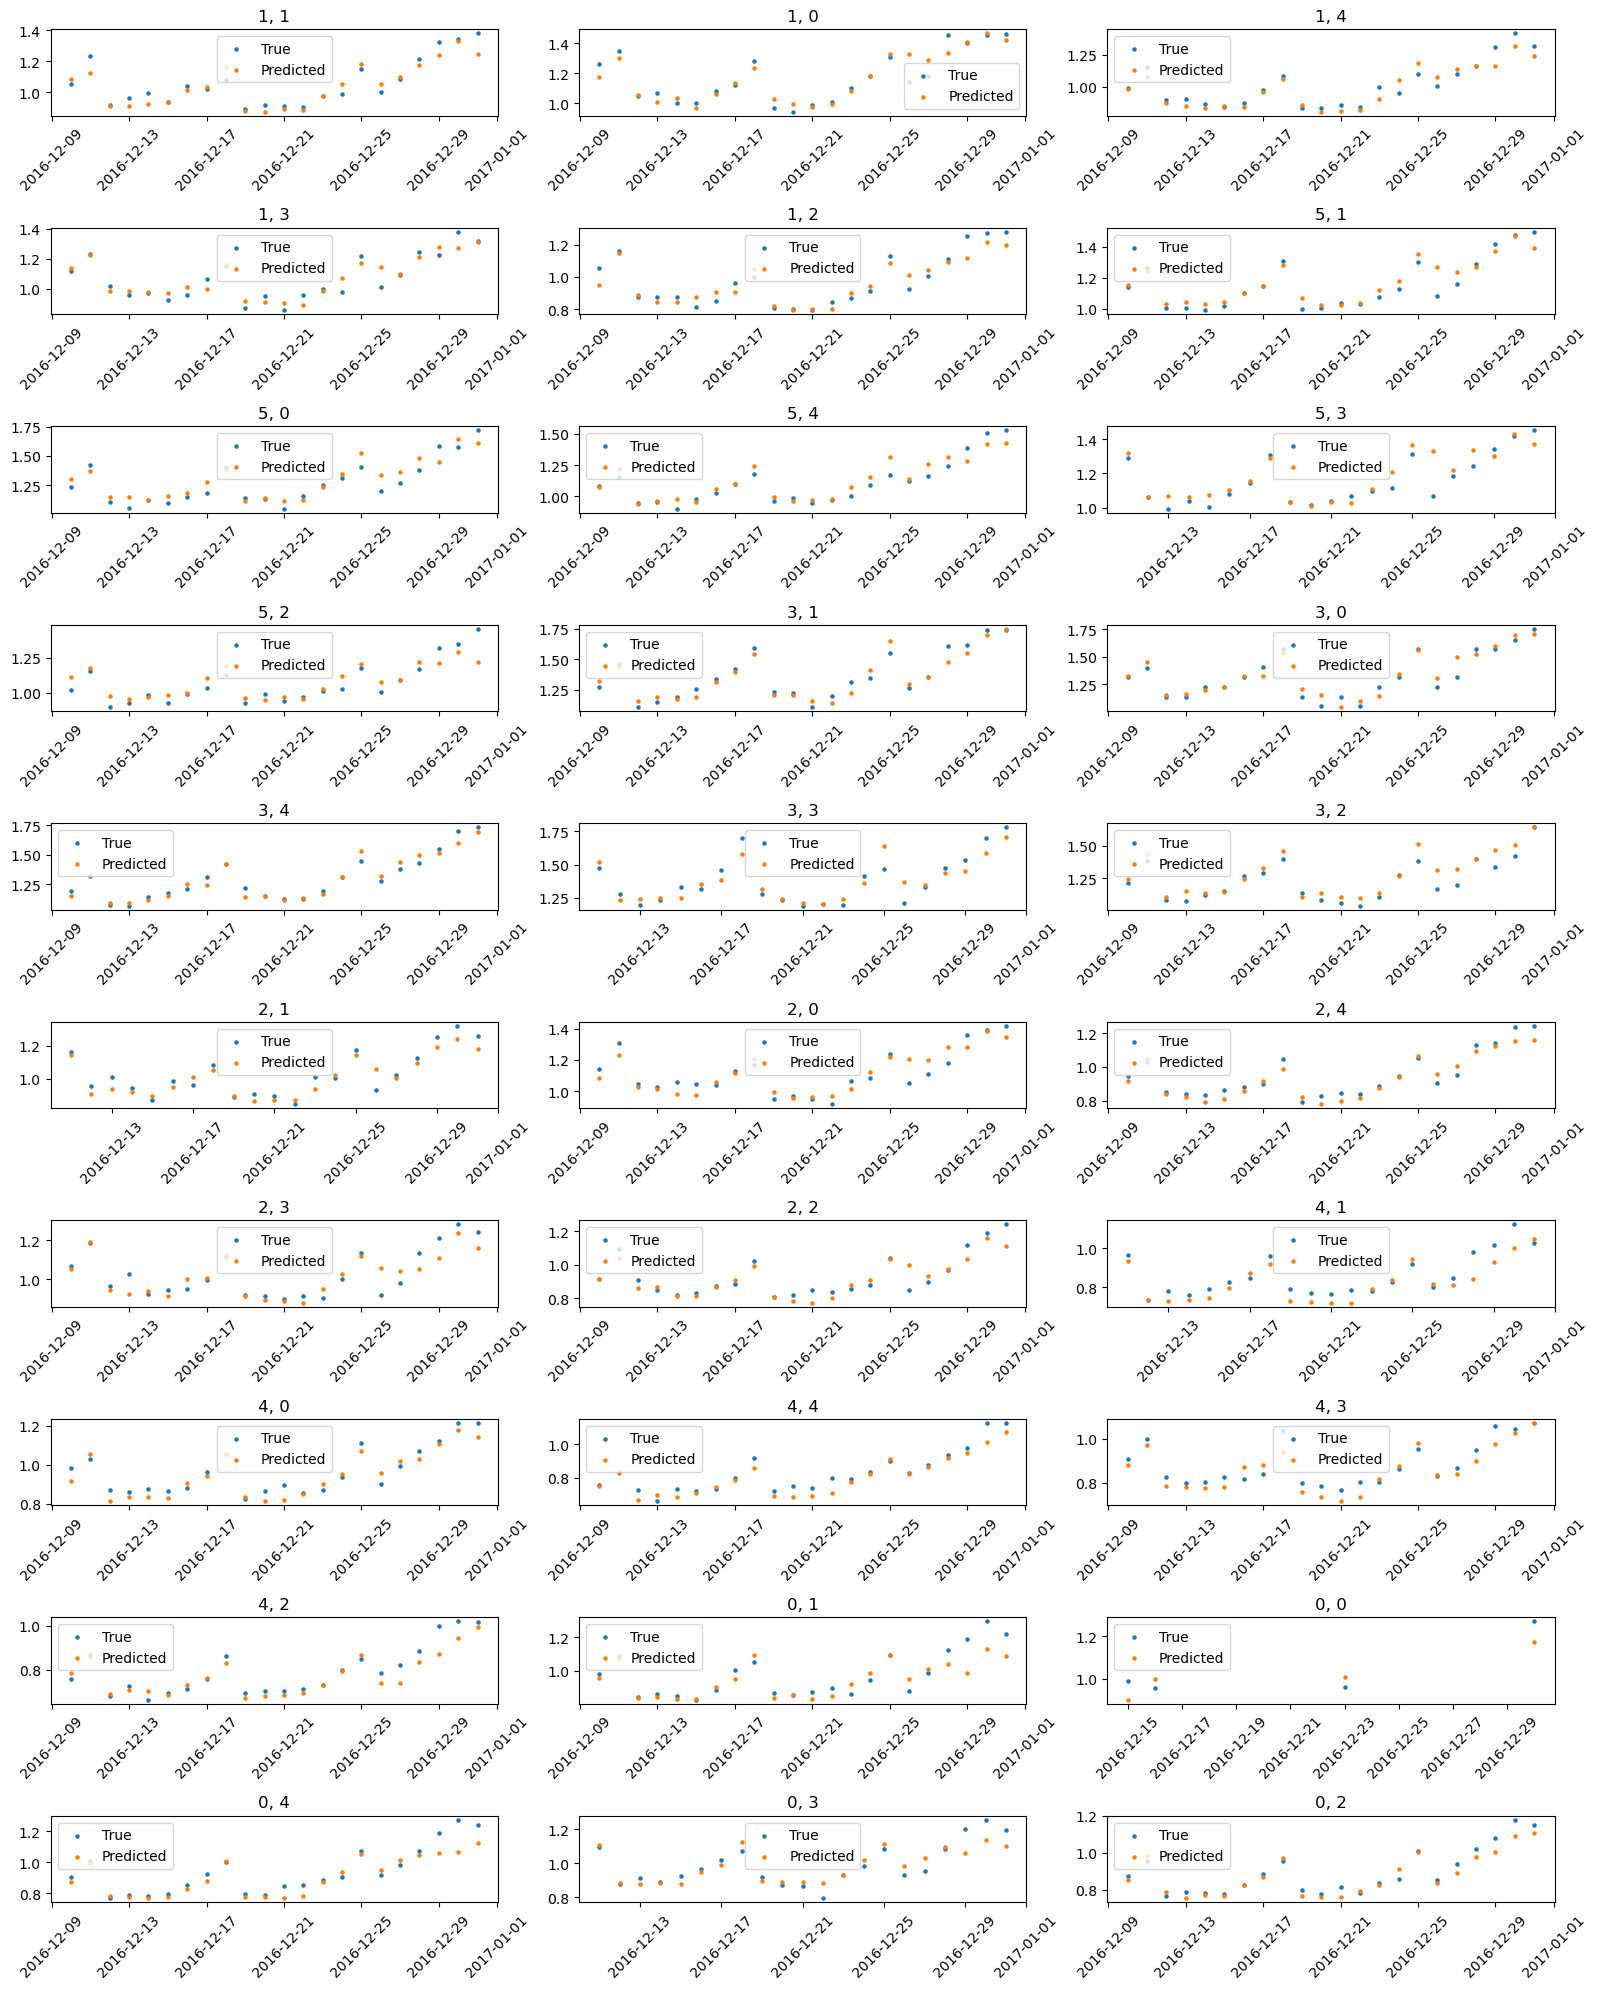

In [25]:
cols = [(c,p) for c in test["country"].unique() for p in test["product"].unique()]
preds = ["rescaled_sold", "pred"]

plot_predict_comparison(test, cols, preds, ncols=3, figsize=(16, 20), intensity = 5)

In [49]:
import optuna
from lightgbm import LGBMRegressor

def objective_LGB(trial):

    model = LGBMRegressor(
        n_estimators = trial.suggest_int("n_estimators", 500, 3000),
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.15),
        num_leaves = trial.suggest_int("num_leaves", 20, 200),
        max_depth = trial.suggest_int("max_depth", 3, 12),
        min_child_samples = trial.suggest_int("min_child_samples", 10, 150),
        subsample = trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha = trial.suggest_float("reg_alpha", 0.0, 3.0),
        reg_lambda = trial.suggest_float("reg_lambda", 0.0, 3.0),
        random_state = 0,
        n_jobs = -1,
        verbosity = -1 
    )

    # IMPORTANT: fit once before validation
    train, _ = train_test_split(df, perc)
    X_train = train[features].values
    y_train = train["rescaled_sold"].values
    model.fit(X_train, y_train)

    rmse = compute_rmse(df, perc, model)

    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective_LGB, n_trials=3)

print("Best RMSE:", study.best_value)
print("Best parameters:", study.best_params)


[I 2026-02-25 00:04:24,318] A new study created in memory with name: no-name-06dd4dd0-479d-426c-9481-58196c629561
[I 2026-02-25 00:04:26,740] Trial 0 finished with value: 0.05520015989749862 and parameters: {'n_estimators': 934, 'learning_rate': 0.1485542871902814, 'num_leaves': 196, 'max_depth': 5, 'min_child_samples': 111, 'subsample': 0.7917285977355176, 'colsample_bytree': 0.8246431734518169, 'reg_alpha': 2.224659070110371, 'reg_lambda': 1.8700810228672653}. Best is trial 0 with value: 0.05520015989749862.
[I 2026-02-25 00:04:30,553] Trial 1 finished with value: 0.05409382989742965 and parameters: {'n_estimators': 2099, 'learning_rate': 0.014153486802588013, 'num_leaves': 52, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.8901515340941335, 'colsample_bytree': 0.8044417784864273, 'reg_alpha': 1.8334643293105874, 'reg_lambda': 2.31606121734408}. Best is trial 1 with value: 0.05409382989742965.
[I 2026-02-25 00:04:34,668] Trial 2 finished with value: 0.05633261130020145 and p

Best RMSE: 0.05409382989742965
Best parameters: {'n_estimators': 2099, 'learning_rate': 0.014153486802588013, 'num_leaves': 52, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.8901515340941335, 'colsample_bytree': 0.8044417784864273, 'reg_alpha': 1.8334643293105874, 'reg_lambda': 2.31606121734408}


In [27]:
best_model = LGBMRegressor(**study.best_params)
best_model.fit(X, y)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 57249, number of used features: 17
[LightGBM] [Info] Start training from score 1.020214


LGBMRegressor(colsample_bytree=0.9616754231079883,
              learning_rate=0.030006179886984202, max_depth=8,
              min_child_samples=71, n_estimators=1578, num_leaves=20,
              reg_alpha=2.7874786506515434, reg_lambda=2.127362268203644,
              subsample=0.673615623531157)

In [29]:
compute_rmse(df, perc, best_model)

0.05304348494706285

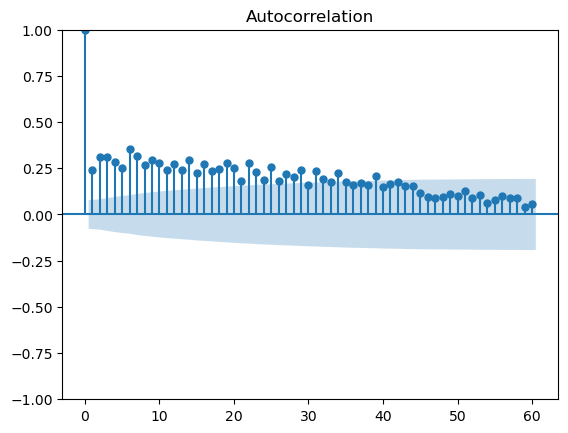

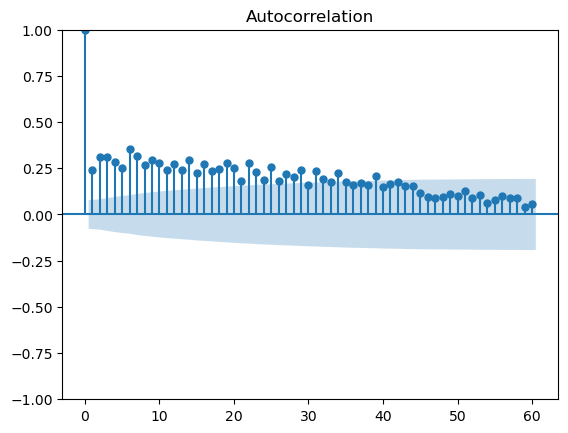

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_test - pred, lags=60)

# With Ridge

In [34]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

def objective_ridge(trial):

    alpha = trial.suggest_float("alpha", 1e-4, 100.0, log=True)

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha, random_state=0))
    ])

    # IMPORTANT: fit once before validation
    train, _ = train_test_split(df, perc)
    X_train = train[features].values
    y_train = train["rescaled_sold"].values

    model.fit(X_train, y_train)

    rmse = compute_rmse(df, perc, model)

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective_ridge, n_trials=10)

print("Best RMSE:", study.best_value)
print("Best parameters:", study.best_params)


[I 2026-02-24 23:51:34,207] A new study created in memory with name: no-name-5d24e88a-9695-4d80-b0a8-bb7d36070193
[I 2026-02-24 23:51:34,350] Trial 0 finished with value: 0.08278851156620923 and parameters: {'alpha': 0.03287312688357448}. Best is trial 0 with value: 0.08278851156620923.
[I 2026-02-24 23:51:34,476] Trial 1 finished with value: 0.08279266816297924 and parameters: {'alpha': 0.05100680776410168}. Best is trial 0 with value: 0.08278851156620923.
[I 2026-02-24 23:51:34,608] Trial 2 finished with value: 0.08278216772170725 and parameters: {'alpha': 0.005391193411077016}. Best is trial 2 with value: 0.08278216772170725.
[I 2026-02-24 23:51:34,729] Trial 3 finished with value: 0.08299031569802974 and parameters: {'alpha': 1.047842119961042}. Best is trial 2 with value: 0.08278216772170725.
[I 2026-02-24 23:51:34,854] Trial 4 finished with value: 0.08429219715979908 and parameters: {'alpha': 64.60075531966612}. Best is trial 2 with value: 0.08278216772170725.
[I 2026-02-24 23:51

Best RMSE: 0.08278094699262271
Best parameters: {'alpha': 0.0001295887196986957}


In [36]:
df_full = create_features(df).dropna()

X_full = df_full[features].values
y_full = df_full["rescaled_sold"].values

best_model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=study.best_params["alpha"], random_state=0))
])

best_model_ridge.fit(X_full, y_full)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.0001295887196986957, random_state=0))])

In [38]:
compute_rmse(df, perc, best_model_ridge)

0.08185044372179921

# With LASSO


In [41]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

def objective_lasso(trial):

    alpha = trial.suggest_float("alpha", 1e-5, 10.0, log=True)

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(
            alpha=alpha,
            max_iter=10000, #number of coordinate descent steps to compute the lasso estimator
            random_state=0
        ))
    ])

    # Fit once before validation (required for your setup)
    train, _ = train_test_split(df, perc)
    X_train = train[features].values
    y_train = train["rescaled_sold"].values

    model.fit(X_train, y_train)

    rmse = compute_rmse(df, perc, model)

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective_lasso, n_trials=10)

print("Best RMSE:", study.best_value)
print("Best parameters:", study.best_params)


[I 2026-02-24 23:51:44,414] A new study created in memory with name: no-name-924041f6-d7d3-43e1-9a3e-0de337bf0455
[I 2026-02-24 23:51:44,542] Trial 0 finished with value: 0.22246179571128483 and parameters: {'alpha': 1.0580837446507236}. Best is trial 0 with value: 0.22246179571128483.
[I 2026-02-24 23:51:44,865] Trial 1 finished with value: 0.08482041400716821 and parameters: {'alpha': 0.00018008667197045469}. Best is trial 1 with value: 0.08482041400716821.
[I 2026-02-24 23:51:45,054] Trial 2 finished with value: 0.14318713430416252 and parameters: {'alpha': 0.03235649314361562}. Best is trial 1 with value: 0.08482041400716821.
[I 2026-02-24 23:51:45,252] Trial 3 finished with value: 0.14994269894383105 and parameters: {'alpha': 0.04355299499112759}. Best is trial 1 with value: 0.08482041400716821.
[I 2026-02-24 23:51:45,520] Trial 4 finished with value: 0.08538713800290787 and parameters: {'alpha': 0.00035018746067830276}. Best is trial 1 with value: 0.08482041400716821.
[I 2026-02-

Best RMSE: 0.08440849964793426
Best parameters: {'alpha': 4.902120823178269e-05}


In [43]:
df_full = create_features(df).dropna()

X_full = df_full[features].values
y_full = df_full["rescaled_sold"].values

best_model_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=study.best_params["alpha"], random_state=0))
])

best_model_lasso.fit(X_full, y_full)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=4.902120823178269e-05, random_state=0))])

In [45]:
compute_rmse(df, perc, best_model_lasso)

0.08185042817909365